Better handling of the horizontal barcodes.

Problem of the previous approach: we compute the sum of gradients intensities (vertical and horizontal) on the whole original image. Despite the fact that this works on the dataset images, this is less robust: what if the image contains, outside tha non-rotated barcode (i.e. vertical bars), a lot of vertical changes? The barcode would be recognized as rotated.

For solving this, a more robust approach has been followed.
- First of all, the morphologic operations use the exact same kernels, both for the non-rotated and rotated cases. In this way, we don't need to recognize if the barcode is rotated or not in order to detect it.
- After detecting the bounding box surrounding the barcode and after having computed the warping, we now understand if the barcode is rotated or not. We do so by computing the sum of gradients intensities (vertical and horizontal) on the warped bounding box image: this is much more reliable (only the barcode itself is taken into account). Then, if the barcode is rotated, we rotated the warped image.

In [1]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [2]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('images') if isfile(join('images', f))])

In [3]:
image_path_example = f'images/{images_paths[10]}'

(1024, 1280, 3)


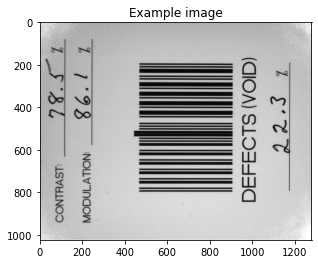

In [4]:
image = cv2.imread(image_path_example)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(gray, 'gray')
plt.title('Example image');

## 1) COMPUTING REGIONS WITH HIGH ABSOLUTE DIFFERENCE HORIZONTAL DERIVATIVE - VERTICAL DERIVATIVE 
As previous approach.

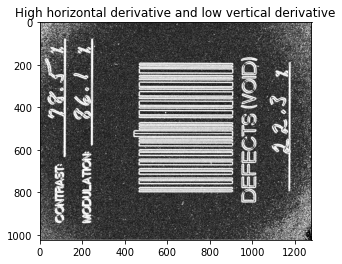

In [6]:
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

plt.figure()
plt.imshow(gradient, 'gray')
plt.title('High horizontal derivative and low vertical derivative');

## 2) BLURRING

As in the previous approach.

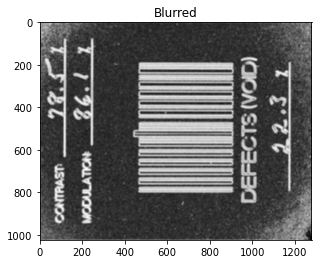

In [7]:
blurred = cv2.blur(gradient, (9, 9))

plt.figure()
plt.imshow(blurred, 'gray')
plt.title('Blurred');

## 3) BINARY THRESHOLDING (OTSU'S ALGORITHM)
As in the previous approach.

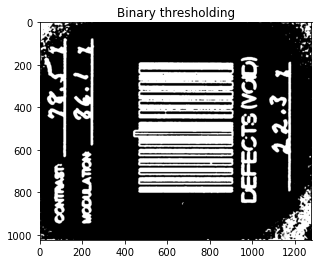

In [8]:
# Threshold, Otsu's algorithm
ret2,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure()
plt.imshow(thresh, 'gray')
plt.title('Binary thresholding');

## 4) FILLING THE BOUNDINX BOX (CLOSING OPERATOR)
Symmetric kernel $25 \times 25$, both if vertical and horizontal barcode. Bigger closing operation.

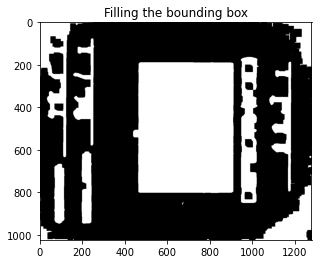

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed, 'gray')
plt.title('Filling the bounding box');

### The size of the structuring element is important
If it is too big, too many foreground pixels are enlighted, making the bounding box detection more difficult.

If it is too small, the barcode can be not fully detected. Like in the following example.

In [12]:
def plot_bounding_box(binary_image, gray_image, original_image, title=''):
    cnts = cv2.findContours(binary_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    rect = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    
    image_bb = original_image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    plt.title(title)

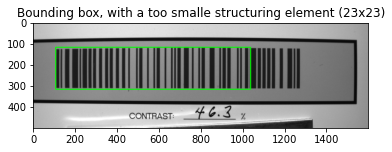

In [17]:
image_path_example_tmp = f'images/{images_paths[13]}'

image_tmp = cv2.imread(image_path_example_tmp)
gray_tmp = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)

# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray_tmp, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray_tmp, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient_tmp = cv2.subtract(gradX, gradY)
gradient_tmp = cv2.convertScaleAbs(gradient_tmp)

blurred_tmp = cv2.blur(gradient_tmp, (9, 9))

# Threshold, Otsu's algorithm
ret2,thresh_tmp = cv2.threshold(blurred_tmp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (23, 23))
closed_tmp = cv2.morphologyEx(thresh_tmp, cv2.MORPH_CLOSE, kernel)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
opened_tmp = cv2.morphologyEx(closed_tmp, cv2.MORPH_OPEN, kernel)

plot_bounding_box(opened_tmp, gray_tmp, image_tmp, title='Bounding box, with a too smalle structuring element (23x23)')

## 5) REMOVING THINGS OUTSIDE THE BOX (OPENING OPERATOR)

We have to use a bigger kernel with respect than before, because we have use a bigger closing operation before. $50 \times 50$ structuring element, instead of $30 \times 30$.

Text(0.5, 1.0, 'Removing things outside the box')

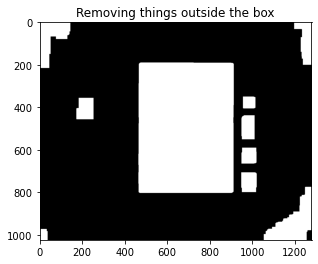

In [18]:
# Remove small things outside
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opened, 'gray')
plt.title('Removing things outside the box')

## 6) ENLARGING THE WIDTH OF THE BOX (DILATION OPERATOR)
Symmetric kernel $8 \times 8$, both if vertical and horizontal barcode.

We do this still for the same reason: we want to be sure the fully contain all the barcodes along the width (since we don't know in which direction the actual width of the box is, we have to use a symmetric kernel). 

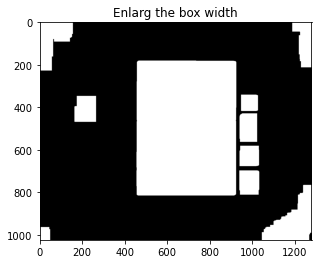

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
dilated = cv2.dilate(opened, kernel, iterations=3)

plt.figure()
plt.imshow(dilated, 'gray')
plt.title('Enlarg the box width');

### The size of the structuring element is important
We don't want to enlarge the box too much, because this could affect the shape of the box, and thus affect the correct rotation of the barcode. Small dilation.

### End of the preprocessing
After this step, we have finished the pre-processing operations. We are now sure to have a box (i.e. foreground object) containing the whole barcode. Both along the width and height.

This both if the barcode is rotated (i.e. horizontal) or not (i.e. vertical).

## 7) BOUNDING BOX DETECTION (OpenCV API)

As in the previous approach.

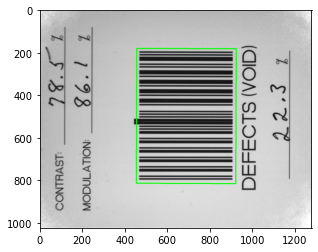

In [20]:
# Bounding box

# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
#print(rect)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
#print(box)
# draw a bounding box arounded the detected barcode and display the
# image

image_bb = image.copy()
cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(image_bb, 'gray')

## 8) WARPING: REMOVAL OF PERSPECTIVE DISTORTION AND ROTATION (HOMOGRAPHY)

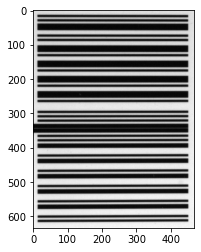

In [21]:
coordinates_source = box.astype('float32')
#print(sorted([tuple(v) for v in coordinates_source], key=lambda t: (t[1],t[0])))
#print(np.sort(coordinates_source))

min_width = coordinates_source[:,0].min()
min_height = coordinates_source[:,1].min()
max_width = coordinates_source[:,0].max()
max_height = coordinates_source[:,1].max()
def normalize(value, axis=0):
    if axis==0:  # Horizontal dimension
        return min_width if (value-min_width<max_width-value) \
                         else max_width
    elif axis==1:  # Vertical dimension
        return min_height if (value-min_height<max_height-value) \
                          else max_height
coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                            normalize(t[0], axis=0))))

def dist(point1, point2):
    return np.sqrt(np.sum((point1-point2)**2))

destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                         dist(coordinates_source[1],coordinates_source[3])]))
destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                         dist(coordinates_source[2],coordinates_source[3])]))
coordinates_destination = np.array([[0, 0],
                                    [destination_width-1, 0],
                                    [0, destination_height-1],
                                    [destination_width-1, destination_height-1]], dtype='float32')


# Computing the trasformation, i.e. homography. Warping.
H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)

# Applying the trasformation
gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))

plt.imshow(gray1, 'gray')

The barcode is rotated, not correct!

## 9) ROTATING THE WARPED IMAGE
Finally, we have to understand if the barcode is rotated or not. If yes, we have to rotated the warped image accordingly.

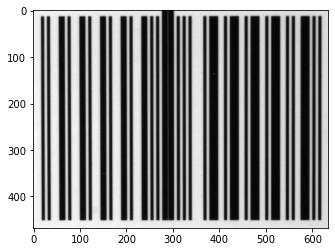

In [22]:
# We undertand if the barcode is rotated or not by computing the horizontal and vertical gradients: if the sum on the 
# latter is bigger tha  the sum on the former, this means that the barcode is horizontal, i.e. rotated.
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray1, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray1, ddepth=ddepth, dx=0, dy=1, ksize=-1)

if cv2.convertScaleAbs(gradY).sum()>cv2.convertScaleAbs(gradX).sum():  # THE BARCODE IS ROTATED
    
    # We compute a new homography/warping, for rotating it.
    destination_height_rot, destination_width_rot = destination_width, destination_height
    coordinates_destination_rot = np.array([[destination_width_rot-1, 0],
                                            [destination_width_rot-1, destination_height_rot-1],
                                            [0, 0],                                        
                                            [0, destination_height_rot-1]], dtype='float32')

    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_destination, coordinates_destination_rot)

    # Applying the trasformation
    gray1_rot = cv2.warpPerspective(gray1, H, (destination_width_rot, destination_height_rot))

    plt.figure()
    plt.imshow(gray1_rot, 'gray')